# Introduction

This notebook documents possible solutions that could be implemented to increase the accuracy of a Convolutional Neural Network (CNN) model when only small available datasets are provided.

## Table of Content

- [1 - Installation of libraries](#1)
- [2 - Packages](#2)
- [3 - Data Augmentation](#3)
- [4 - Building small dataset](#4)
- [5 - Our Model](#5)
    - [5.1 - Transfer Learning using Residual Network (ResNet)](#5-1)
    - [5.2 - Defining loss function and optimizer](#5-2)
- [6 - Training the model](#6)
    - [6.1 - Results (Training)](#6-1)
- [7 - Testing the model](#7)
    - [7.1 - Results (Testing)](#7-1)

    


<a name='1'></a>
## 1 - Installation of libraries (if not installed)

In [ ]:
%pip install torch torchvision

In [ ]:
%pip install numpy

In [ ]:
%pip install matplotlib

<a name='2'></a>
## 2 - Packages

In [1]:
import ssl
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# To resolve certificate error
ssl._create_default_https_context = ssl._create_unverified_context

# Check if GPU is available to be used
device = torch.device('cuda:0' if torch.cuda.is_available()else 'cpu')
print(device)

cuda:0


<a name='3'></a>
## 3 - Data Augmentation



In [3]:
train_transform = transforms.Compose([
     transforms.Resize(256), 
     transforms.CenterCrop(224),
     #transforms.ColorJitter(brightness=0.5),
     #transforms.RandomRotation(degrees=45),
     transforms.RandomHorizontalFlip(p=0.5),
     #transforms.RandomCrop(224),
     transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.226)
)])

test_transform = transforms.Compose([
     transforms.Resize(256), 
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.226)
)])

<a name='4'></a>
## 4 - Building small dataset



In [4]:

batch_size = 5
ap_num, am_num,bird_num,cat_num,deer_num = 0,0,0,0,0

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=train_transform)
ap_indices, am_indices, bird_indices, cat_indices, deer_indices = [],[],[],[],[]
ap_idx, am_idx, bird_idx, cat_idx, deer_idx = trainset.class_to_idx['airplane'], trainset.class_to_idx['automobile'], trainset.class_to_idx['bird'], trainset.class_to_idx['cat'], trainset.class_to_idx['deer']
for i in range(len(trainset)):
  current_class = trainset[i][1]
  if current_class == ap_idx:
    if ap_num<50:
      ap_indices.append(i)
      ap_num+=1
  elif current_class == am_idx:
    if am_num<50:
      am_indices.append(i)
      am_num+=1
  elif current_class == bird_idx:
    if bird_num<50:
      bird_indices.append(i)
      bird_num+=1
  elif current_class == cat_idx:
    if cat_num<50:
      cat_indices.append(i)
      cat_num+=1
  elif current_class == deer_idx:
    if deer_num<50:
      deer_indices.append(i)
      deer_num+=1

print('Number of airplane images:%d'%ap_num)
print('Number of automobile images:%d'%am_num)
print('Number of bird images:%d'%bird_num)
print('Number of cat images:%d'%cat_num)
print('Number of deer images:%d'%deer_num)

new_train = torch.utils.data.Subset(trainset,ap_indices+am_indices+bird_indices+cat_indices+deer_indices)

trainloader = torch.utils.data.DataLoader(new_train, batch_size = batch_size,
                                          shuffle=True, num_workers=2)

ap_num, am_num,bird_num,cat_num,deer_num = 0,0,0,0,0

testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=test_transform)
ap_indices, am_indices, bird_indices, cat_indices, deer_indices = [],[],[],[],[]
ap_idx, am_idx, bird_idx, cat_idx, deer_idx = testset.class_to_idx['airplane'], testset.class_to_idx['automobile'], testset.class_to_idx['bird'], testset.class_to_idx['cat'], testset.class_to_idx['deer']
for i in range(len(testset)):
  current_class = testset[i][1]
  if current_class == ap_idx:
    if ap_num<30:
      ap_indices.append(i)
      ap_num+=1
  elif current_class == am_idx:
    if am_num<30:
      am_indices.append(i)
      am_num+=1
  elif current_class == bird_idx:
    if bird_num<30:
      bird_indices.append(i)
      bird_num+=1
  elif current_class == cat_idx:
    if cat_num<30:
      cat_indices.append(i)
      cat_num+=1
  elif current_class == deer_idx:
    if deer_num<30:
      deer_indices.append(i)
      deer_num+=1

print('Number of airplane images:%d'%ap_num)
print('Number of automobile images:%d'%am_num)
print('Number of bird images:%d'%bird_num)
print('Number of cat images:%d'%cat_num)
print('Number of deer images:%d'%deer_num)

new_test = torch.utils.data.Subset(testset,ap_indices+am_indices+bird_indices+cat_indices+deer_indices)

testloader = torch.utils.data.DataLoader(new_test, batch_size = batch_size,
                                         shuffle=False, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer')
           

Files already downloaded and verified
Number of airplane images:50
Number of automobile images:50
Number of bird images:50
Number of cat images:50
Number of deer images:50
Files already downloaded and verified
Number of airplane images:30
Number of automobile images:30
Number of bird images:30
Number of cat images:30
Number of deer images:30


### Displaying augmented images from training dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


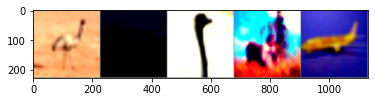

 bird airplane  bird  deer airplane


In [5]:

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' %classes[labels[j]] for j in range(batch_size)))

<a name='5'></a>
## 5 - Our Model

<a name='5-1'></a>
### 5.1 - Transfer Learning using Residual Network (ResNet)



In [6]:

resnet101 = models.resnet101(pretrained=True).to(device)
for param in resnet101.parameters():
    param.requires_grad = False

resnet101.to(device).fc = nn.Sequential(nn.Linear(2048, 1024),
                                        nn.ReLU(),
                                        #nn.Dropout(0.4),
                                        #nn.Linear(1024, 512),
                                        #nn.ReLU(),
                                        #nn.Dropout(0.5),
                                        #nn.Linear(256, 128),
                                        #nn.ReLU(),
                                        #nn.Dropout(0.5),
                                        #nn.Linear(128, 64),
                                        #nn.ReLU(),
                                        #nn.Dropout(0.5),
                                        #nn.Linear(64, 32),
                                        #nn.ReLU(),
                                        nn.Dropout(0.4),
                                        nn.Linear(1024, 5))
    
resnet101.to(device).eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

<a name='5-2'></a>
### 5.2 - Defining loss function and optimizer for our model

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet101.to(device).parameters(), lr=0.001, momentum=0.9)

<a name='6'></a>
## 6 - Training the model

In [8]:
running_corrects = 0
total = 0
train_loss = []
train_acc = []

for epoch in range(100):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = resnet101(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)

        running_loss += loss.item()
        total += labels.size(0)
        running_corrects += (predicted == labels).sum().item()
        

        if i%50 == 49:
            print('[%d, %5d]    Loss: %.3f   Accuracy: %.6f'%(epoch+1,i+1,running_loss/50,running_corrects/total))
            train_loss.append(running_loss/50)
            train_acc.append(running_corrects/total)
            running_loss =0.0
            
print('Finished Training')


[1,    50]    Loss: 1.397   Accuracy: 0.460000
[2,    50]    Loss: 0.892   Accuracy: 0.588000
[3,    50]    Loss: 0.685   Accuracy: 0.648000
[4,    50]    Loss: 0.579   Accuracy: 0.679000
[5,    50]    Loss: 0.531   Accuracy: 0.704000
[6,    50]    Loss: 0.516   Accuracy: 0.725333
[7,    50]    Loss: 0.492   Accuracy: 0.740000
[8,    50]    Loss: 0.401   Accuracy: 0.754000
[9,    50]    Loss: 0.397   Accuracy: 0.764000
[10,    50]    Loss: 0.324   Accuracy: 0.778000
[11,    50]    Loss: 0.370   Accuracy: 0.785091
[12,    50]    Loss: 0.339   Accuracy: 0.792333
[13,    50]    Loss: 0.278   Accuracy: 0.801846
[14,    50]    Loss: 0.297   Accuracy: 0.807714
[15,    50]    Loss: 0.349   Accuracy: 0.812000
[16,    50]    Loss: 0.319   Accuracy: 0.818000
[17,    50]    Loss: 0.328   Accuracy: 0.822118
[18,    50]    Loss: 0.312   Accuracy: 0.825333
[19,    50]    Loss: 0.352   Accuracy: 0.828211
[20,    50]    Loss: 0.305   Accuracy: 0.831600
[21,    50]    Loss: 0.317   Accuracy: 0.833143
[

<a name='6-1'></a>
## 6.1 - Results (Training)

### Loss Curve

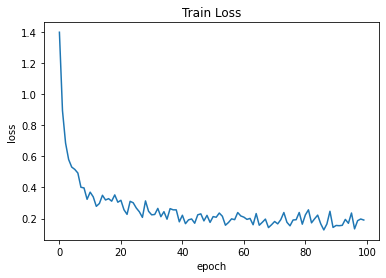

In [9]:
plt.plot(train_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train Loss')
plt.show()

### Accuracy Curve

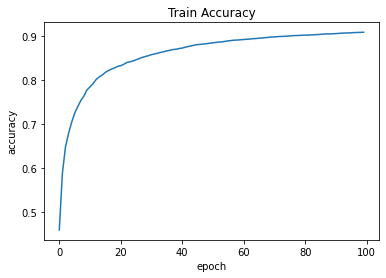

In [10]:
plt.plot(train_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train Accuracy')
plt.show()

### Save weights

In [11]:
PATH = './cifar_net.pth'
torch.save(resnet101.to(device).state_dict(), PATH)

### Displaying images from testing dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


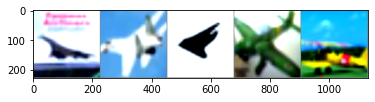

GroundTruth: airplane airplane airplane airplane airplane 


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth:',''.join('%5s ' % classes[labels[j]] for j in range(batch_size)))

<a name='7'></a>
## 7 - Testing the model

### Load weights & Carry out prediction

In [13]:
resnet101.to(device).load_state_dict(torch.load(PATH))

outputs = resnet101(images.to(device))

_, predicted = torch.max(outputs,1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size)))


Predicted:  airplane airplane airplane airplane airplane


<a name='7-1'></a>
## 7.1 - Results (Testing)

### Overall Accuracy

In [14]:
correct = 0
total = 0

with torch.no_grad():
   for data in testloader:
       images, labels = data
       images = images.to(device)
       labels = labels.to(device)
       outputs = resnet101(images)
       #print(outputs.shape)
       #print(F.softmax(outputs, dim=1)*100.0)
       #print(torch.max(outputs.data))
       #print(labels)
       _, predicted = torch.max(outputs.data, 1)
       #print(predicted)
       total += labels.size(0)
       #print(total)
       correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' %(100*correct/total)) 



Accuracy: 90 %


### Accuracy of each class

In [15]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet101(images)
        _, predictions = torch.max(outputs,1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100*float(correct_count)/total_pred[classname]
    print('Accuracy for class {:5s} is : {:.1f} %'.format(classname,accuracy))

Accuracy for class airplane is : 96.7 %
Accuracy for class automobile is : 96.7 %
Accuracy for class bird  is : 80.0 %
Accuracy for class cat   is : 96.7 %
Accuracy for class deer  is : 80.0 %
